## Import

In [1154]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from scipy import stats
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report
from xgboost import XGBClassifier

## Data Load

In [1155]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [1156]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               748 non-null    object 
 1   generation                       748 non-null    int64  
 2   school1                          748 non-null    int64  
 3   major type                       726 non-null    object 
 4   major1_1                         728 non-null    object 
 5   major1_2                         309 non-null    object 
 6   major_data                       748 non-null    bool   
 7   job                              748 non-null    object 
 8   class1                           748 non-null    int64  
 9   class2                           169 non-null    float64
 10  class3                           14 non-null     float64
 11  class4                           1 non-null      float64
 12  re_registration       

**Insight**
1. previous_class_3~8 : non-null 개수가 동일함

     -한 번이라도 이전 기수에 들은 경험이 있는 사람이면, 
     - 안 들은 기수는 '해당없음'을 넣고, 들은 기수는 분반명 (예시= 0001 : 파이썬 문법 기초반)이 기입돼있음
     -특기할 점은, 이전에 들은 경험이 있는 사람은 같은 강좌를 여러 번 듣는 게 아니라 다른 강좌를 듣고 와서 또 듣는 식이라 수료율이 매우 높음!!

2. class1~class4
 - 이번 기수에 듣는 분반(강좌)번호
 - 여러 개 듣는 경우(4개까지) -> class1부터 class4까지 하나씩 분반숫자를 기입
 - 따라서 class3, class4는 대부분 결측치
 - 오름차순으로 적는 것이므로 같은 분반 번호가 class1에 적히나 class4에 적히나 차이가 없음
 - One-Hot encoding으로 분반을 처리하는 등의 조치가 필요해보임 (test dataset에는 trainset에 등장하지 않은 분반이 등장함에 유의)
 - 여러 강좌를 듣는 사람(3개 동시 수강)의 경우 수료율이 높아 보임 -> 몇 개 분반을 듣는 지를 변수로 추가

 3. contest_award, contest_participation, idea_contest는 training set이나 test set에서 채워진 행이 단 하나도 없음 -> 당연히 컬럼 삭제

 4. 응답 형태가 다양한 컬럼 (희망회사명, 현직자 강의 규모 선택 이유)은 한국어NLP모델을 사용하여 분석하지 않는 이상, 과감히 없애는 게 나아보임.
  - 희망회사명은 '없음', '모르겠음', 'NaN' 등의 결과인지만 체크하는 식으로 가공하는 것도 좋아보임.
  - 아직 명확한 희망직무가 없는 사람이므로 수료할 가능성이 낮다고 볼 수 있기 때문

**왤케 머할지 모르겠고 막막하냐.. ㅜㅜ 일단 변수를 하나씩 컨트롤해봅시다**

In [1157]:
drop_cols = ['ID', 'generation', 'contest_award', 'contest_participation', 'idea_contest', 'whyBDA']

## school1 변수
- int64 type이지만 실제로는 범주형 변수 (모델이 숫자를 '크기'로 인식하게 하면 안됨)
- training set에는 없지만 test set에는 있거나, training set에 매우 적은 수로 존재하는 학교를 '기타'로 처리
- 이후 'category' type으로 처리하도록 하여 XGBClassifier 모델이 인식할 수 있도록 함.

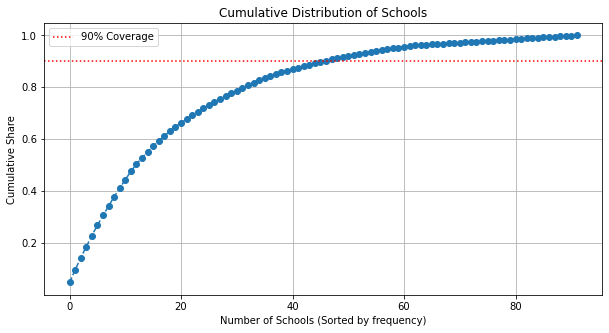

In [1158]:
# 학교별 빈도수 계산 및 정렬
school_counts = train['school1'].value_counts()
# 누적 합계 및 비율 계산
cumulative_shares = school_counts.cumsum() / len(train)

plt.figure(figsize=(10, 5))
plt.plot(range(len(cumulative_shares)), cumulative_shares.values, marker='o', linestyle='--')
plt.axhline(y=0.9, color='r', linestyle=':', label='90% Coverage') # 90% 선
plt.title('Cumulative Distribution of Schools')
plt.xlabel('Number of Schools (Sorted by frequency)')
plt.ylabel('Cumulative Share')
plt.legend()
plt.grid(True)
plt.show()

In [1159]:
# 빈도 구간별 학교 수 확인
print(f"전체 학교 수: {len(school_counts)}")
for i in range(1, 6):
    num_schools = len(school_counts[school_counts <= i])
    percentage = (school_counts[school_counts <= i].sum() / len(train)) * 100
    print(f"빈도가 {i}번 이하인 학교 수: {num_schools}개 (전체 데이터의 {percentage:.2f}%)")

전체 학교 수: 92
빈도가 1번 이하인 학교 수: 29개 (전체 데이터의 3.88%)
빈도가 2번 이하인 학교 수: 35개 (전체 데이터의 5.48%)
빈도가 3번 이하인 학교 수: 43개 (전체 데이터의 8.69%)
빈도가 4번 이하인 학교 수: 51개 (전체 데이터의 12.97%)
빈도가 5번 이하인 학교 수: 55개 (전체 데이터의 15.64%)


In [1160]:
# 기준 설정: 예를 들어 5명 미만인 학교는 '기타'로 분류
# 이 숫자는 EDA를 통해 적절히 조절 가능합니다.
school_threshold = 3
common_schools = school_counts[school_counts >= school_threshold].index.tolist()

def preprocess_school(df, common_list):
    # copy를 사용하여 원본 데이터 훼손 방지
    new_df = df.copy()
    
    # common_list에 없는 학교는 모두 -1 (또는 특정 숫자)로 통일
    # 훈련 데이터의 희소 학교 + 테스트 데이터의 새로운 학교가 모두 -1이 됨
    new_df['school1_grouped'] = new_df['school1'].apply(lambda x: x if x in common_list else -1)
    
    return new_df

# 변환 적용
train = preprocess_school(train, common_schools)
test = preprocess_school(test, common_schools)

# 결과 확인
print(f"변환 후 Train 내 유니크 학교 수: {train['school1_grouped'].nunique()}")
print(f"변환 후 Test 내 유니크 학교 수: {test['school1_grouped'].nunique()}")

# 기존의 school1_grouped (정수형)를 카테고리 타입으로 바꾸고, 기존 school1 컬럼 없애기
train['school1_grouped'] = train['school1_grouped'].astype('category')
test['school1_grouped'] = test['school1_grouped'].astype('category')
drop_cols.append('school1')

변환 후 Train 내 유니크 학교 수: 58
변환 후 Test 내 유니크 학교 수: 58


## 전공관련 변수 전처리
- major type, major1_1, major1_2 없애기
- major_field에서 결측치 처리하고, 콤마(',') 기준으로 문자열 나눈 후 해당 문자열을 가지고 있는지를 체크
- major_data: bool 변수 -> int로 변경

In [1161]:
drop_cols += ['major type', 'major1_1', 'major1_2']
# '자연고학'이라는 글자를 찾아서 '자연과학'으로 변경 
# regex=False를 설정하여 단순 문자열 치환임을 명시 (성능 및 안정성 향상)
train['major_field'] = train['major_field'].str.replace('자연고학', '자연과학', regex=False)

# (만약 테스트 셋에도 있을 수 있으니 동일하게 적용)
test['major_field'] = test['major_field'].str.replace('자연고학', '자연과학', regex=False)

# 문자열을 리스트로 변환하는 함수 정의
def tokenize_major(text):
    if pd.isna(text):
        return []
    # 쉼표로 분리 + 콤마 뒤쪽 공백 제거 (예: '자연과학, 사회과학'-> ['자연과학', '사회과학'])
    return [item.strip() for item in str(text).split(',')]

# 전공 리스트 컬럼 생성
train['major_list'] = train['major_field'].apply(tokenize_major)
test['major_list'] = test['major_field'].apply(tokenize_major)

# MultiLabelBinarizer 학습 및 변환
mlb = MultiLabelBinarizer()

# Train 데이터로 기준(클래스)을 잡고 변환
train_encoded = mlb.fit_transform(train['major_list'])

# Test 데이터는 Train에서 만든 기준에 맞춰 변환만 수행
# (Train에 없던 전공이 Test에 나올 경우 무시됨 - 일관성 유지)
test_encoded = mlb.transform(test['major_list'])

# 데이터프레임으로 변환하여 기존 데이터와 결합
major_columns = [f'major_{c}' for c in mlb.classes_]

train_major_df = pd.DataFrame(train_encoded, columns=major_columns, index=train.index)
test_major_df = pd.DataFrame(test_encoded, columns=major_columns, index=test.index)
print(f"생성된 전공 컬럼들: {major_columns}")
train = pd.concat([train, train_major_df], axis=1)
test = pd.concat([test, test_major_df], axis=1)

# 불필요해진 원본 및 중간 컬럼 삭제
drop_cols += ['major_field', 'major_list']

print(f"새로 생성된 전공 컬럼 개수: {len(major_columns)}개")

# major_data 컬럼을 bool형에서 정수형으로 변환
train['major_data'] = train['major_data'].astype(int)

생성된 전공 컬럼들: ['major_IT (컴퓨터 공학 포함)', 'major_경영학', 'major_경제통상학', 'major_공학 (컴퓨터 공학 제외)', 'major_교육학', 'major_법학', 'major_사회과학', 'major_예체능', 'major_의약학', 'major_인문학', 'major_자연과학']
새로 생성된 전공 컬럼 개수: 11개


## Job 전처리

In [1162]:
# 빈도수가 5회 미만인 직업은 '기타'로 통합
job_counts = train['job'].value_counts()
rare_jobs = job_counts[job_counts < 5].index.tolist()
print(f"빈도수가 5회 미만인 직업들: {rare_jobs}")

빈도수가 5회 미만인 직업들: []


In [1163]:
# job 컬럼을 'category' 타입으로 변환
train['job'] = train['job'].astype('category')
test['job'] = test['job'].astype('category')

## Class1 ~ Class4 전처리

In [1164]:
def check_class_distribution(df, name="Dataset"):
    # 4개 컬럼의 값을 하나로 합침 (결측치 제외)
    all_classes = df[['class1', 'class2', 'class3', 'class4']].values.flatten()
    all_classes = all_classes[~pd.isna(all_classes)]
    
    # 빈도수 계산
    dist = pd.Series(all_classes).value_counts().sort_index()
    
    print(f"--- {name} Class Distribution ---")
    print(f"Total Unique Classes: {len(dist)}")
    print(f"Class Range: {dist.index.min()} ~ {dist.index.max()}")
    print(dist)
    print("\n")

# 실행
check_class_distribution(train, "Train")
check_class_distribution(test, "Test")

--- Train Class Distribution ---
Total Unique Classes: 10
Class Range: 1.0 ~ 13.0
1.0     128
2.0     149
4.0     180
5.0     108
6.0      96
7.0      66
8.0      78
11.0     30
12.0     41
13.0     56
dtype: int64


--- Test Class Distribution ---
Total Unique Classes: 11
Class Range: 1.0 ~ 16.0
1.0     102
2.0     187
4.0     180
5.0     138
6.0      82
7.0      73
8.0      64
12.0     55
14.0     72
15.0    116
16.0     40
dtype: int64




In [1165]:
def preprocess_classes(train_df, test_df):
    """
    class1~class4 컬럼을 기반으로 수강 강좌 수(class_count)를 생성하고,
    실제 관측된 분반 번호들만 추출하여 Multi-Label One-Hot Encoding을 수행합니다.
    """
    class_cols = ['class1', 'class2', 'class3', 'class4']
    
    # 1. 수강 강좌 수(Feature) 생성
    train_df['class_count'] = train_df[class_cols].notna().sum(axis=1)
    test_df['class_count'] = test_df[class_cols].notna().sum(axis=1)

    # 2. 각 행의 분반 번호를 리스트로 추출 (정수형 변환)
    def get_class_list(row):
        return [int(x) for x in row if pd.notna(x)]

    train_lists = train_df[class_cols].apply(get_class_list, axis=1)
    test_lists = test_df[class_cols].apply(get_class_list, axis=1)

    # 3. Train과 Test에서 실제 관측된 모든 분반 번호의 합집합 추출 (3번 등 미등장 번호 자동 제외)
    train_observed = set([c for sublist in train_lists for c in sublist])
    test_observed = set([c for sublist in test_lists for c in sublist])
    final_classes = sorted(list(train_observed | test_observed))

    # 4. MultiLabelBinarizer 적용 (명시적인 클래스 범위 지정)
    mlb = MultiLabelBinarizer(classes=final_classes)
    
    # Train 데이터 기반 학습 및 변환, Test 데이터는 동일 기준 변환
    train_encoded = mlb.fit_transform(train_lists)
    test_encoded = mlb.transform(test_lists)

    # 5. 인코딩된 결과를 데이터프레임으로 변환 및 결합
    class_columns = [f'class_{c}' for c in mlb.classes_]
    
    train_encoded_df = pd.DataFrame(train_encoded, columns=class_columns, index=train_df.index)
    test_encoded_df = pd.DataFrame(test_encoded, columns=class_columns, index=test_df.index)

    train_df = pd.concat([train_df, train_encoded_df], axis=1)
    test_df = pd.concat([test_df, test_encoded_df], axis=1)

    return train_df, test_df

# 실행 및 원본 컬럼 관리
train, test = preprocess_classes(train, test)
drop_cols.extend(['class1', 'class2', 'class3', 'class4'])

## re-registration

In [1166]:
# 계속 재사용할 함수!!
def check_col_distribution(train_df, test_df, col):
    print(f"--- {col} 분포 확인 ---")
    print(f"\n[Train]")
    print(train_df[col].value_counts(dropna=False))
    
    print(f"\n[Test]")
    print(test_df[col].value_counts(dropna=False))
    
    # 두 셋의 유니크 값 차이 확인
    train_vals = set(train_df[col].unique())
    test_vals = set(test_df[col].unique())
    
    if train_vals != test_vals:
        print(f"\n[Warning] 불일치 발견!")
        print(f"Train에만 있음: {train_vals - test_vals}")
        print(f"Test에만 있음: {test_vals - train_vals}")
    else:
        print(f"\n[Info] Train/Test의 범주가 일치합니다.")

# 실행
check_col_distribution(train, test, 're_registration')

--- re_registration 분포 확인 ---

[Train]
아니요    602
예      146
Name: re_registration, dtype: int64

[Test]
아니요    659
예      155
Name: re_registration, dtype: int64

[Info] Train/Test의 범주가 일치합니다.


In [1167]:
# 1. 매핑 딕셔너리 생성
# '아니요'는 0(신규), '예'는 1(재등록)로 설정합니다.
re_reg_map = {'아니요': 0, '예': 1}

# 2. Train 및 Test 데이터 변환
train['re_registration'] = train['re_registration'].map(re_reg_map)
test['re_registration'] = test['re_registration'].map(re_reg_map)

# 3. 데이터 타입 정수형(int) 확정
# 결측치가 발생할 경우를 대비해 fillna(0)를 포함하는 것이 안전합니다.
train['re_registration'] = train['re_registration'].fillna(0).astype(int)
test['re_registration'] = test['re_registration'].fillna(0).astype(int)

### Nationality

In [1168]:
check_col_distribution(train, test, 'nationality')

--- nationality 분포 확인 ---

[Train]
내국인    745
외국인      2
NaN      1
Name: nationality, dtype: int64

[Test]
내국인    810
외국인      4
Name: nationality, dtype: int64

[Warning] 불일치 발견!
Train에만 있음: {nan}
Test에만 있음: set()


- 외국인 사실상 없는 수준 -> 컬럼 삭제

In [1169]:
drop_cols += ['nationality']

## Inflow Route

In [1170]:
check_col_distribution(train, test, 'inflow_route')

--- inflow_route 분포 확인 ---

[Train]
에브리타임                               340
기존 학회원 또는 운영진                       150
인스타그램                               121
지인 추천                                78
대외활동 사이트(링커리어, 캠퍼스픽, 캠퍼즈, 위비티 등)     55
기타                                    2
교내 플랫폼 (에브리타임 X)                      1
인터넷 검색                                1
Name: inflow_route, dtype: int64

[Test]
에브리타임                               419
인스타그램                               156
기존 BDA 오픈채팅방                         89
지인 추천                                77
대외활동 사이트(링커리어, 캠퍼스픽, 캠퍼즈, 위비티 등)     62
직장인 커뮤니티(블라인드, 링크드인 등)                5
B.D.A 행사 (잡페스티벌, WAVE)                2
기존 BDA 학회원                            1
인터넷 검색                                1
bda 9기활동                              1
네이버 블로그                               1
Name: inflow_route, dtype: int64

[Warning] 불일치 발견!
Train에만 있음: {'기존 학회원 또는 운영진', '교내 플랫폼 (에브리타임 X)', '기타'}
Test에만 있음: {'직장인 커뮤니티(블라인드, 링크드인 등)', '네이버 블로그', '기존 BD

In [1171]:
def preprocess_inflow_route(train_df, test_df, threshold=10):
    # 1. '기존' 키워드가 포함된 유입 경로 통합
    def unify_existing(x):
        if pd.isna(x):
            return '기타'
        if '기존' in str(x):
            return '기존_유입'
        return x

    train_df['inflow_route'] = train_df['inflow_route'].apply(unify_existing)
    test_df['inflow_route'] = test_df['inflow_route'].apply(unify_existing)

    # 2. Train 데이터 기준으로 빈도수 계산
    route_counts = train_df['inflow_route'].value_counts()
    
    # 빈도가 threshold(10) 이상인 경로들만 추출
    common_routes = route_counts[route_counts >= threshold].index.tolist()

    # 3. 10개 미만인 데이터 및 Test에만 있는 새로운 경로는 '기타'로 통합
    def group_rare_routes(x):
        if x in common_routes:
            return x
        return '기타'

    train_df['inflow_route'] = train_df['inflow_route'].apply(group_rare_routes)
    test_df['inflow_route'] = test_df['inflow_route'].apply(group_rare_routes)

    # 4. XGBoost를 위해 category 타입으로 변환
    train_df['inflow_route'] = train_df['inflow_route'].astype('category')
    test_df['inflow_route'] = test_df['inflow_route'].astype('category')

    return train_df, test_df

# 전처리 실행
train, test = preprocess_inflow_route(train, test)

# 결과 확인
print("전처리 후 Train 유입 경로 분포:\n", train['inflow_route'].value_counts())
print("\n전처리 후 Test 유입 경로 분포:\n", test['inflow_route'].value_counts())

전처리 후 Train 유입 경로 분포:
 에브리타임                               340
기존_유입                               150
인스타그램                               121
지인 추천                                78
대외활동 사이트(링커리어, 캠퍼스픽, 캠퍼즈, 위비티 등)     55
기타                                    4
Name: inflow_route, dtype: int64

전처리 후 Test 유입 경로 분포:
 에브리타임                               419
인스타그램                               156
기존_유입                                90
지인 추천                                77
대외활동 사이트(링커리어, 캠퍼스픽, 캠퍼즈, 위비티 등)     62
기타                                   10
Name: inflow_route, dtype: int64


## what_to_gain & hope_for_group

In [1172]:
check_col_distribution(train, test, 'what_to_gain')
check_col_distribution(train, test, 'hope_for_group')

--- what_to_gain 분포 확인 ---

[Train]
데이터 분석 역량                                                                          492
프로젝트 경험                                                                            149
공모전 경험                                                                              73
인적 네트워크                                                                             29
기초적인 python, sql 지식 숙지                                                               1
위 항목 전체                                                                              1
공모전과 프로젝트                                                                            1
사실 한가지를 고르기 어렵습니다..ㅠㅠ 학회를 통해 위의 4가지와 협업에 계신 전문가님들에게 유익한 정보를 얻고 소중한 경험을 하고 싶습니다.      1
분석 역량, 공모전 경험, 인적 네트워크                                                               1
Name: what_to_gain, dtype: int64

[Test]
데이터 분석 역량                                                                        502
프로젝트 경험                                                

In [1173]:
def preprocess_categorical_col(train_df, test_df, col_name, threshold=10):
    """
    특정 컬럼에서 빈도가 낮은(10개 미만) 항목을 '기타'로 통합하고
    category 타입으로 변환합니다.
    """
    # 1. Train 데이터 기준으로 빈도수 계산
    gain_counts = train_df[col_name].value_counts()
    
    # 10개 이상 등장하는 주요 항목 리스트 추출
    common_gains = gain_counts[gain_counts >= threshold].index.tolist()

    # 2. 통합 함수 정의
    # 주요 항목에 포함되지 않거나 Test에만 등장하는 새로운 값은 '기타'로 처리
    def group_rare_gains(x):
        if x in common_gains:
            return x
        return '기타'

    # 3. 변환 적용
    train_df[col_name] = train_df[col_name].apply(group_rare_gains)
    test_df[col_name] = test_df[col_name].apply(group_rare_gains)

    # 4. XGBoost 활용을 위해 category 타입으로 변환
    train_df[col_name] = train_df[col_name].astype('category')
    test_df[col_name] = test_df[col_name].astype('category')

    return train_df, test_df

# 전처리 실행
train, test = preprocess_categorical_col(train, test, 'what_to_gain')

# 결과 확인
print("전처리 후 Train 얻고자 하는 것 분포:\n", train['what_to_gain'].value_counts())
print("\n전처리 후 Test 얻고자 하는 것 분포:\n", test['what_to_gain'].value_counts())

전처리 후 Train 얻고자 하는 것 분포:
 데이터 분석 역량    492
프로젝트 경험      149
공모전 경험        73
인적 네트워크       29
기타             5
Name: what_to_gain, dtype: int64

전처리 후 Test 얻고자 하는 것 분포:
 데이터 분석 역량    502
프로젝트 경험      198
공모전 경험        79
인적 네트워크       32
기타             3
Name: what_to_gain, dtype: int64


In [1174]:
train['hope_for_group'] = train['hope_for_group'].astype('category')
test['hope_for_group'] = test['hope_for_group'].astype('category')

## previous_class3~8
- 이전에 수업 몇 번 들었는지 체크 (prev_attendance_count)
- 위에서 만들었던 re_registration 변수의 정보가 여기에 포함되므로 그냥 삭제

In [1175]:
def create_experience_feature(df):
    # 1. 대상 컬럼 리스트 정의
    prev_cols = [f'previous_class_{i}' for i in range(3, 9)]
    
    # 2. 누적 참여 횟수 계산
    # '없음'이 아니면서 결측치도 아닌 경우를 카운트
    df['prev_attendance_count'] = df[prev_cols].apply(
        lambda x: (x != '해당없음') & (x.notna()), axis=1
    ).sum(axis=1)
    
    return df

# Train 및 Test 적용
train = create_experience_feature(train)
test = create_experience_feature(test)

# 결과 확인
print("참여 횟수별 데이터 수 (Train):\n", train['prev_attendance_count'].value_counts())

drop_cols += ['previous_class_3', 'previous_class_4', 'previous_class_5',
              'previous_class_6', 'previous_class_7', 'previous_class_8', 're_registration']

참여 횟수별 데이터 수 (Train):
 0    603
1    117
2     21
3      5
6      1
4      1
Name: prev_attendance_count, dtype: int64


## desired_career_path / completed_semester

In [1176]:
check_col_distribution(train, test, 'desired_career_path')
check_col_distribution(train, test, 'completed_semester')

--- desired_career_path 분포 확인 ---

[Train]
취업        573
대학원 진학    143
이직         24
창업          8
Name: desired_career_path, dtype: int64

[Test]
취업          601
대학원 진학      169
이직           26
창업            9
현재 직장 유지      9
Name: desired_career_path, dtype: int64

[Warning] 불일치 발견!
Train에만 있음: set()
Test에만 있음: {'현재 직장 유지'}
--- completed_semester 분포 확인 ---

[Train]
6.00        205
8.00        193
4.00        134
7.00         74
5.00         40
2.00         29
NaN          28
9.00         20
3.00         10
10.00         9
20241.00      2
1.00          2
2020.02       1
0.00          1
Name: completed_semester, dtype: int64

[Test]
5.0     170
7.0     168
8.0     154
6.0      90
NaN      74
3.0      63
4.0      41
9.0      30
2.0      11
10.0      9
1.0       4
Name: completed_semester, dtype: int64

[Warning] 불일치 발견!
Train에만 있음: {nan, 0.0, 2020.02, 20241.0}
Test에만 있음: {nan}


In [1177]:
train, test = preprocess_categorical_col(train, test, 'desired_career_path')

- 'semester' 컬럼을 남기는 게 좋을지 상관계수 및 p-value를 통해 확인

In [1178]:
# 이상치(Outlier)를 NaN으로 처리하거나 적절한 값으로 수정
# 10학기를 초과하는 값은 상식적인 이수 학기를 벗어나므로 NaN 처리 후 나중에 채우는 것이 안전합니다.
def clean_semester(df):
    # 1. 상식적인 범위를 벗어나는 값(예: 12학기 초과)은 NaN으로 변환
    df['completed_semester'] = df['completed_semester'].apply(
        lambda x: x if (pd.notna(x) and 0 <= x <= 12) else np.nan
    )
    return df

# 중앙값으로 채우기 (정수 형태 유지를 위해)
semester_median = train['completed_semester'].median()
train['completed_semester'] = train['completed_semester'].fillna(semester_median)
test['completed_semester'] = test['completed_semester'].fillna(semester_median)

train = clean_semester(train)
test = clean_semester(test)

# NaN을 제외하고 계산
mask = train['completed_semester'].notna()
pb_corr = stats.pointbiserialr(train['completed_semester'][mask], train['completed'][mask])
print(f"Point-Biserial 상관계수: {pb_corr.correlation:.4f} (p-value: {pb_corr.pvalue:.4e})")

Point-Biserial 상관계수: 0.0776 (p-value: 3.4295e-02)


- 선형성은 낮지만, p-value가 유의미하게 나왔으므로 Low, Middle, High의 구간으로 나누기로 함.

In [1179]:
def bin_semester(x):
    if x <= 3: return 'Low'      # 1~2학년 초반
    if x <= 6: return 'Middle'   # 2학년 후반~3학년
    return 'High'                # 4학년 이상

# 새로운 피처 생성
train['semester_group'] = train['completed_semester'].apply(bin_semester).astype('category')
test['semester_group'] = test['completed_semester'].apply(bin_semester).astype('category')

drop_cols += ['completed_semester']

In [1180]:
check_col_distribution(train, test, 'project_type')
train['project_type'] = train['project_type'].astype('category')
test['project_type'] = test['project_type'].astype('category')

--- project_type 분포 확인 ---

[Train]
팀     527
개인    221
Name: project_type, dtype: int64

[Test]
팀     576
개인    238
Name: project_type, dtype: int64

[Info] Train/Test의 범주가 일치합니다.


## time_input

In [1181]:
print(train['time_input'].describe())
correlation = train['time_input'].corr(train['completed'])
print(f"입력 시간과 수료 여부의 상관계수: {correlation:.4f}")

count    748.000000
mean       2.326471
std        1.365925
min        0.000000
25%        2.000000
50%        2.000000
75%        3.000000
max       24.000000
Name: time_input, dtype: float64
입력 시간과 수료 여부의 상관계수: 0.0261


In [1182]:
# 1. IQR 기반 아웃라이어 임계값 계산
Q1 = train['time_input'].quantile(0.25)
Q3 = train['time_input'].quantile(0.75)
IQR = Q3 - Q1
upper_fence = Q3 + 1.5 * IQR

print(f"통계적 아웃라이어 기준(Upper Fence): {upper_fence} 시간 초과")

# 2. 데이터 분리
normal_group = train[train['time_input'] <= upper_fence]
outlier_group = train[train['time_input'] > upper_fence]

# 3. 각 그룹별 상관계수 및 수료율 확인
def analyze_group(df, name):
    corr = df['time_input'].corr(df['completed'])
    mean_comp = df['completed'].mean()
    count = len(df)
    print(f"\n[{name} 그룹 분석]")
    print(f"데이터 개수: {count}개")
    print(f"평균 수료율: {mean_comp:.4f}")
    print(f"시간-수료 상관계수: {corr:.4f}")

analyze_group(normal_group, "정상")
analyze_group(outlier_group, "아웃라이어")

# 4. (추가 팁) 시간대별 수료율 시각화 테이블
print("\n[시간 입력값별 수료율 상세]")
print(train.groupby('time_input')['completed'].agg(['mean', 'count']))

통계적 아웃라이어 기준(Upper Fence): 4.5 시간 초과

[정상 그룹 분석]
데이터 개수: 715개
평균 수료율: 0.2993
시간-수료 상관계수: 0.0191

[아웃라이어 그룹 분석]
데이터 개수: 33개
평균 수료율: 0.2727
시간-수료 상관계수: 0.2119

[시간 입력값별 수료율 상세]
                mean  count
time_input                 
0.0         0.500000      4
0.7         0.000000      1
1.0         0.333333    117
1.5         0.235294     17
2.0         0.278481    395
2.5         0.000000      2
3.0         0.305785    121
4.0         0.379310     58
5.0         0.300000     20
6.0         0.125000      8
7.0         1.000000      1
8.0         0.000000      1
10.0        0.000000      2
24.0        1.000000      1


In [1183]:
def preprocess_time_input(train_df, test_df):
    """
    time_input 컬럼을 3개 그룹으로 구간화하고 
    XGBoost 학습에 최적화된 category 타입으로 변환합니다.
    """
    # 1. 구간 분류 로직 정의
    def get_time_group(x):
        if pd.isna(x): return 'Group_0' # 결측치 처리 (필요시)
        if x < 3:
            return 'Group_0'  # 3시간 미만
        elif x < 6:
            return 'Group_1'  # 3시간 이상 6시간 미만
        else:
            return 'Group_2'  # 6시간 이상

    # 2. Train/Test 데이터에 공통 적용
    # 숫자가 아닌 문자열 라벨을 부여하여 명확하게 범주형임을 명시합니다.
    for df in [train_df, test_df]:
        df['time_group'] = df['time_input'].apply(get_time_group).astype('category')

    # 3. 그룹별 수료율 통계 출력 (Train 기준 검증)
    group_stats = train_df.groupby('time_group', observed=True)['completed'].agg(['mean', 'count']).reset_index()
    print("--- [검증] 그룹별 수료율 분석 ---")
    print(group_stats)
    
    return train_df, test_df

# 전처리 실행
train, test = preprocess_time_input(train, test)
# 불필요한 원본 컬럼 제거
drop_cols.append('time_input')

--- [검증] 그룹별 수료율 분석 ---
  time_group      mean  count
0    Group_0  0.289179    536
1    Group_1  0.326633    199
2    Group_2  0.230769     13


In [1184]:
drop_cols += ['desired_job', 'certificate_acquisition', 'desired_certificate', 'desired_job_except_data', 'incumbents_level',
              'incumbents_lecture', 'incumbents_company_level', 'incumbents_lecture_type', 'incumbents_lecture_scale', 
              'incumbents_lecture_scale_reason', 'interested_company', 'expected_domain', 'onedayclass_topic']

train = train.drop(columns=drop_cols, axis=1)
test = test.drop(columns=drop_cols, axis=1)

## XGBoost Modelling & Validation

In [1185]:
# 1. 학습에 사용할 피처와 타겟 분리
X = train.drop('completed', axis= 1)
y = train['completed']
X_test = test.copy()

# 2. 하이퍼파라미터 설정
# scale_pos_weight: (미수료자 수 / 수료자 수)
# 모델한테 수료자에 더 큰 가중치를 주도록 설정
pos_weight = (y == 0).sum() / (y == 1).sum()

xgb_params = {
    'n_estimators': 500,
    'learning_rate': 0.03,
    'max_depth': 4,
    'min_child_weight': 3,
    'subsample': 0.8,  
    'colsample_bytree': 0.6,
    'n_jobs': -1,
    'random_state': 42,
    'scale_pos_weight': 1.0,  
    'enable_categorical': True,      # 이전 전처리에서 설정한 category 타입 활용
    'tree_method': 'hist',           # 범주형 처리를 위해 'hist' 또는 'gpu_hist' 사용 권장
}

# 3. Stratified K-Fold 검증 환경 구축
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
oof_preds = np.zeros(len(X))
test_preds = np.zeros(len(X_test))

print(f"--- 학습 시작 (Feature Count: {X.shape[1]}) ---")

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = XGBClassifier(**xgb_params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    # 확률값(Probability)으로 예측 저장
    oof_preds[val_idx] = model.predict_proba(X_val)[:, 1]
    test_preds += model.predict_proba(X_test)[:, 1] / skf.n_splits

# 4. 최적의 F1-score를 위한 Threshold 검색
best_threshold = 0.5
best_f1 = 0

for thr in np.arange(0.1, 0.9, 0.01):
    score = f1_score(y, (oof_preds > thr).astype(int))
    if score > best_f1:
        best_f1 = score
        best_threshold = thr

print(f"\n--- 최종 결과 ---")
print(f"Best Threshold: {best_threshold:.2f}")
print(f"Best OOF F1-score: {best_f1:.4f}")
print("\n[Classification Report]")
print(classification_report(y, (oof_preds > best_threshold).astype(int)))

--- 학습 시작 (Feature Count: 36) ---

--- 최종 결과 ---
Best Threshold: 0.16
Best OOF F1-score: 0.4565

[Classification Report]
              precision    recall  f1-score   support

           0       0.77      0.34      0.47       525
           1       0.33      0.75      0.46       223

    accuracy                           0.47       748
   macro avg       0.55      0.55      0.47       748
weighted avg       0.64      0.47      0.47       748



In [1186]:
# 1. 예측값(0, 1) 대신 확률값(Probability)을 뽑습니다.
probs = model.predict_proba(X_test)[:, 1]  # 1일 확률만 가져옴

# 2. 최적 임계값을 사용하여 이진 예측 수행
final_pred = (probs >= best_threshold).astype(int)

print(f"임계값 {best_threshold} 적용 시 1 예측 개수: {sum(final_pred)}")

임계값 0.15999999999999998 적용 시 1 예측 개수: 573
